<b>HW5</b> <br>
<b>Name:</b> Varun Pradeep Joshi <br>
<b>Github Username:</b> varunjoshi29 <br>
<b> Usc Id:</b> 1747956384

In [28]:
import pandas as pd
import numpy as np
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [29]:
def print_bold(text):
    print('\033[1m' + text + '\033[0m')

### 1. Decision Trees as Interpretable Models

#### (a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [30]:
df = pd.read_csv('../data/diagnosis.csv', encoding='utf-16', sep='\t',\
names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Bladder_label','Pelvis_label'], header=None)


In [31]:
def clean(temperature):
    first, second = temperature.split(',')
    return first + '.' + second

In [32]:
df['Temperature'] = df['Temperature'].apply(clean)

In [33]:
df

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Bladder_label,Pelvis_label
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


In [34]:
label_encoder = preprocessing.LabelEncoder()

In [35]:
df['Nausea']= label_encoder.fit_transform(df['Nausea'])
df['Lumbar']= label_encoder.fit_transform(df['Lumbar'])
df['Urine']= label_encoder.fit_transform(df['Urine'])
df['Micturition']= label_encoder.fit_transform(df['Micturition'])
df['Urethra']= label_encoder.fit_transform(df['Urethra'])
df['Bladder_label']= label_encoder.fit_transform(df['Bladder_label'])
df['Pelvis_label']= label_encoder.fit_transform(df['Pelvis_label'])

In [36]:
df['Temperature'] = df['Temperature'].astype('float')

In [37]:
df

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Bladder_label,Pelvis_label
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


In [38]:
lps = LabelPowerset()

In [39]:
df['final_label'] = lps.transform(df[['Bladder_label', 'Pelvis_label']])

In [40]:
x_train, y_train = df[['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra']], \
df['final_label']

#### (b) Build a decision tree on the whole data set and plot it.

In [41]:
clf = DecisionTreeClassifier()

In [42]:
clf.fit(x_train, y_train)

DecisionTreeClassifier()

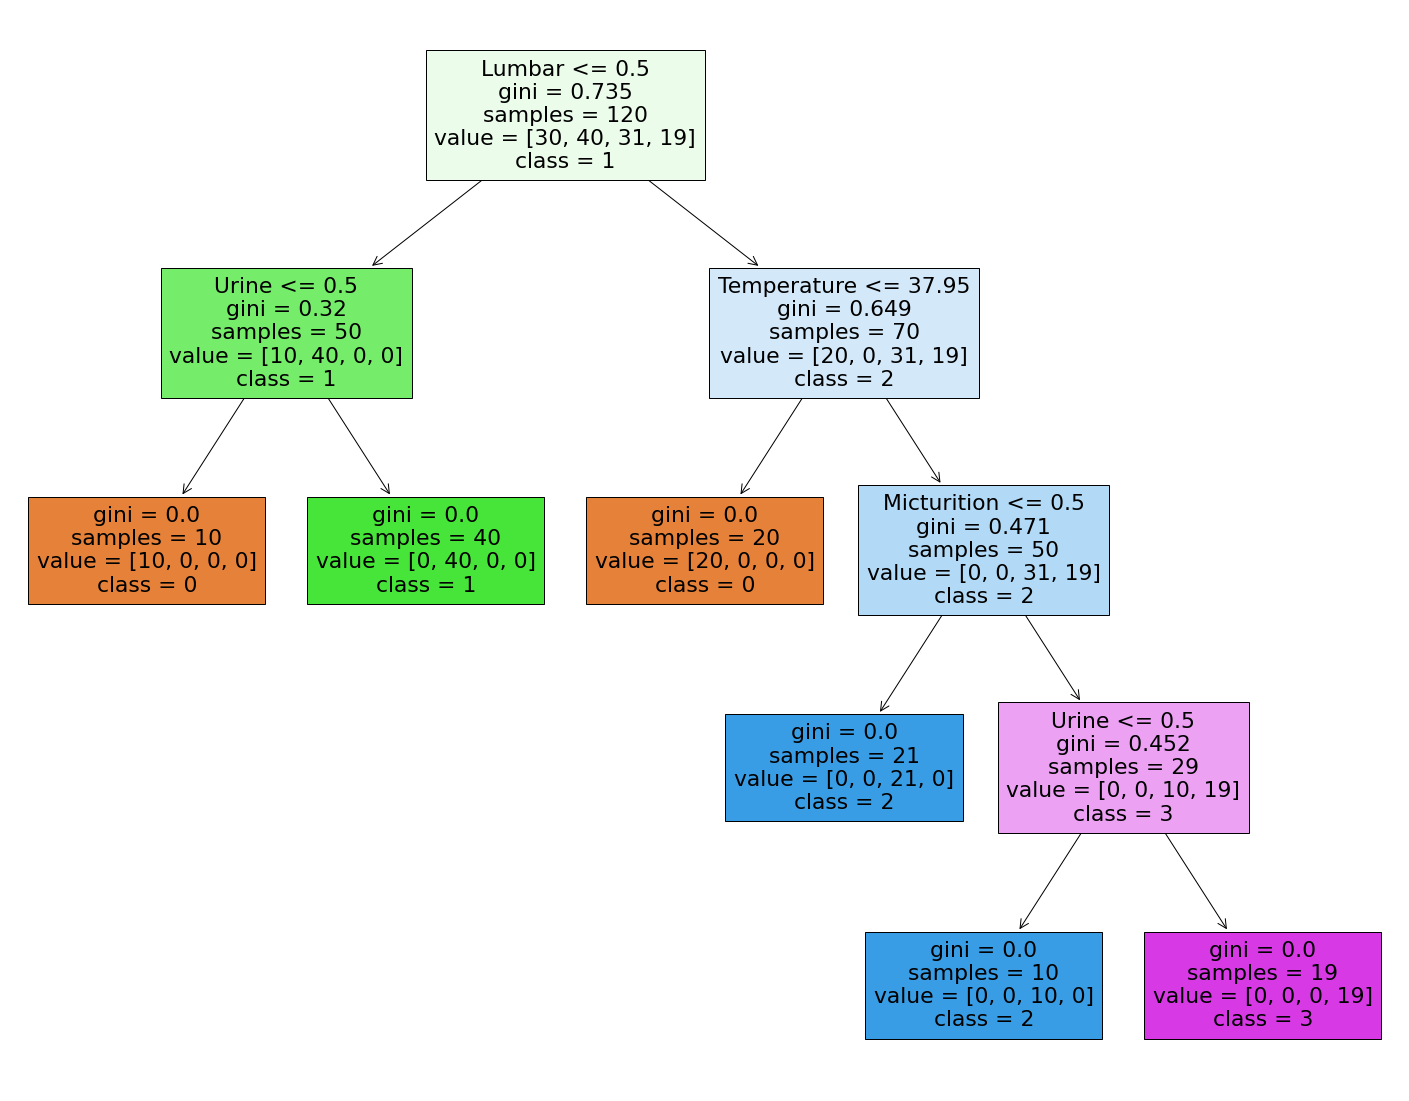

In [43]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=x_train.columns,  
                   class_names= list(map(str,clf.classes_)),
                   filled=True)

#### (c) Convert the decision rules into a set of IF-THEN rules.

In [44]:
# ref: https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
def tree_to_pseudo(tree, feature_names):
    """
    Outputs a decision tree model as if/then pseudocode

    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as pseudocode
    feature_names: list
        The feature names of the dataset used for building the decision tree
    """

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)


In [45]:
tree_to_pseudo(clf, x_train.columns)

 if ( Lumbar <= 0.5 ) {
   if ( Urine <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Micturition <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( Urine <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


#### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [46]:
path = clf.cost_complexity_pruning_path(x_train, y_train)

In [47]:
alphas = path['ccp_alphas']

In [48]:
mean_score = []
for alpha in alphas:
    _tree_ = DecisionTreeClassifier(ccp_alpha=alpha)
    scores = cross_val_score(_tree_, x_train, y_train, cv=5)
    mean_score.append(scores.mean())


In [49]:
mean_score

[0.9583333333333334,
 0.775,
 0.7166666666666667,
 0.6000000000000001,
 0.4333333333333334]

In [50]:
alphas

array([0.        , 0.09816667, 0.13333333, 0.182     , 0.22291667])

<b> As observed from above results, we are getting the best score when alpha = 0, with this, we will get exactly the same decision tree as the one above along with the same IF-THEN decision rules. If a pruned tree is neeeded, taking a non zero alpha with max score. Hence alpha = 0.09816667 </b>

In [51]:
prunedtree_cv = DecisionTreeClassifier(ccp_alpha=0.09816667)
prunedtree_cv.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.09816667)

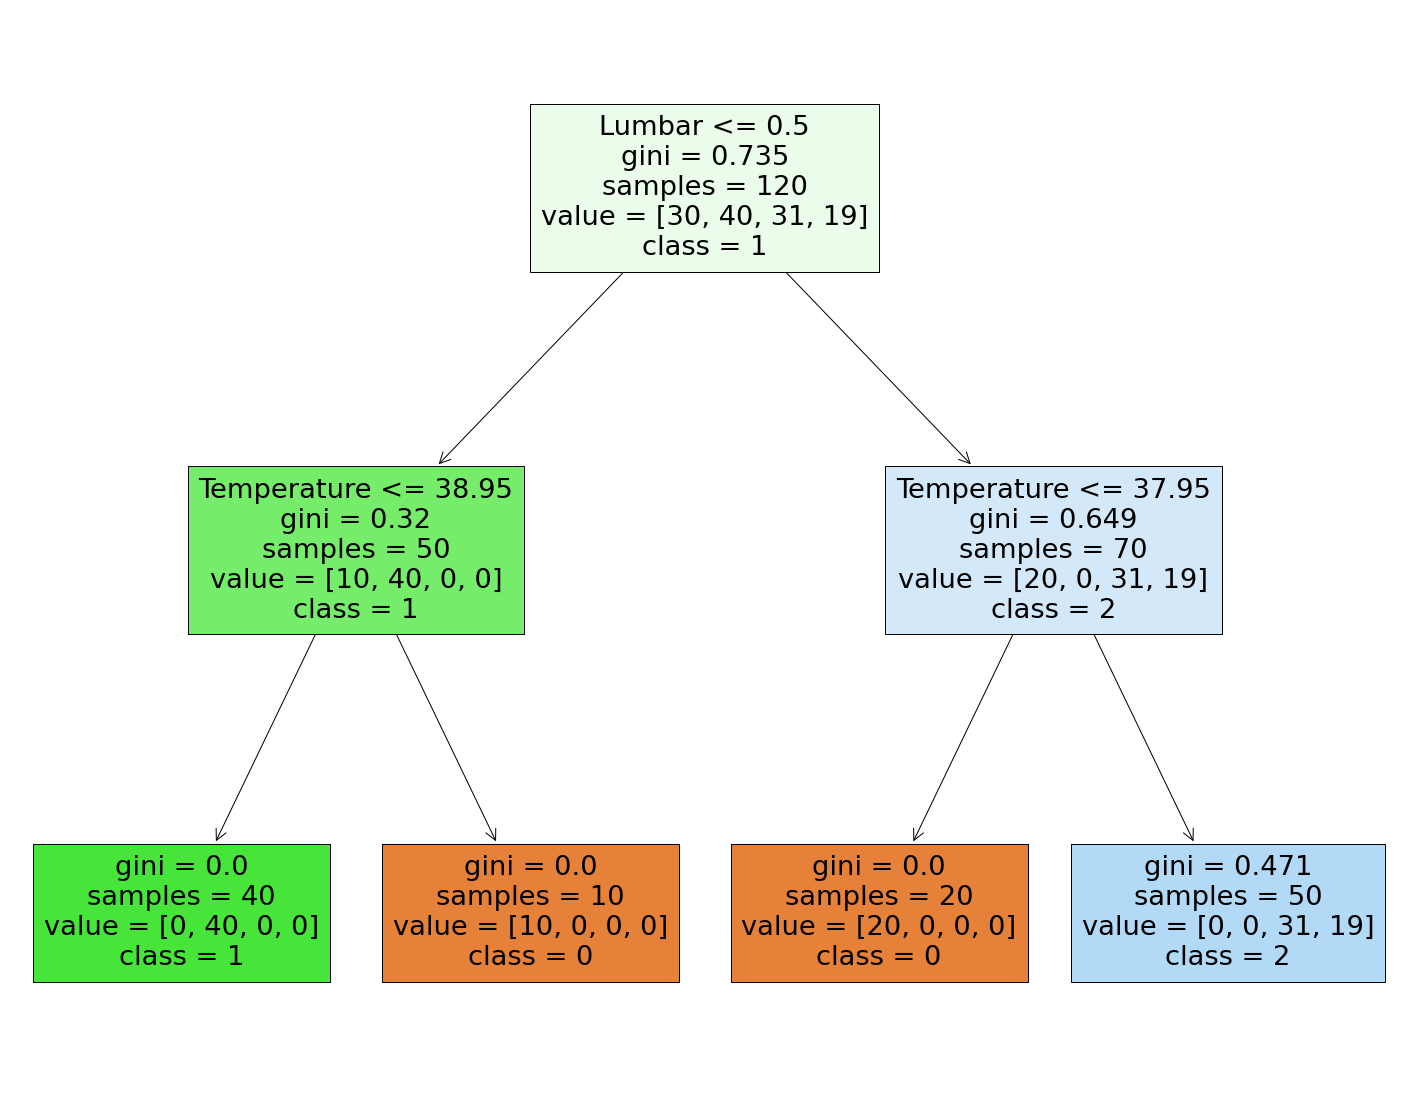

In [52]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(prunedtree_cv, 
                   feature_names=x_train.columns,  
                   class_names= list(map(str,prunedtree_cv.classes_)),
                   filled=True)

**IF-THEN Decision rules for the above tree:**

In [53]:
tree_to_pseudo(prunedtree_cv, x_train.columns)

 if ( Lumbar <= 0.5 ) {
   if ( Temperature <= 38.95000076293945 ) {
     return [[ 0. 40.  0.  0.]]
   } else {
     return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     return [[ 0.  0. 31. 19.]]
   }
 }


### 2. The LASSO and Boosting for Regression

#### (a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [26]:
column_names = []
with open('../data/communities.names', 'r') as file:
    for line in file:
        if line.startswith('@attribute'):
            column_names.append(line.split()[1])            

In [27]:
df2 = pd.read_csv('../data/communities.csv', header=None, na_values='?').iloc[:,5:] #ignoring non predictive features
df2.columns = column_names[5:] #ignoring non predictive features
df2.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


#### (b)The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [28]:
imputer_median = SimpleImputer(strategy='median', missing_values=np.nan)
imputer_median.fit(df2)
imp_df = pd.DataFrame(imputer_median.transform(df2))
imp_df.columns = column_names[5:]
imp_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.08,0.03,0.75,0.5,0.00,0.15,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.08,0.03,0.75,0.5,0.00,0.15,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.03


In [29]:
train_df, test_df = imp_df.iloc[:1495, :], imp_df.iloc[1495:, :]

#### (c) Plot a correlation matrix for the features in the data set.

In [30]:
imp_df[imp_df.columns.drop(['ViolentCrimesPerPop'])].corr()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.222913,0.713652,0.231897,0.270356,0.771741,0.742270,-0.187392,-0.003039,0.466352,0.109434
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,0.015021,-0.015078,-0.004072,-0.051506,-0.065505,-0.037594,0.016074,0.013576,-0.094368,-0.078196
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,-0.001393,0.149758,0.095053,0.147023,0.205748,0.158850,-0.139136,-0.025322,0.260793,0.087642
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.079908,-0.131389,-0.337458,-0.215636,-0.200850,-0.195427,0.114741,0.006167,-0.276234,-0.077442
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,0.152173,-0.001084,0.389944,0.296921,0.022066,0.098876,0.006516,0.049272,0.101888,0.017137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolicOperBudg,0.742270,-0.037594,0.158850,-0.195427,0.098876,0.098898,-0.019937,0.046732,0.021681,-0.031430,...,0.162399,0.494447,0.201027,0.241816,0.820921,1.000000,-0.146793,-0.016920,0.202379,0.311784
LemasPctPolicOnPatr,-0.187392,0.016074,-0.139136,0.114741,0.006516,-0.006605,0.002869,-0.012500,-0.003491,0.009893,...,-0.020521,-0.148576,-0.001321,-0.034349,-0.178242,-0.146793,1.000000,0.035710,-0.172562,-0.277173
LemasGangUnitDeploy,-0.003039,0.013576,-0.025322,0.006167,0.049272,0.006880,0.012554,-0.010717,-0.011441,-0.039631,...,0.083020,0.057715,-0.110503,-0.117694,0.028559,-0.016920,0.035710,1.000000,-0.135341,-0.052814
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,0.136459,0.299632,0.228084,0.206644,0.250818,0.202379,-0.172562,-0.135341,1.000000,0.236636


#### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean.

In [31]:
cv = lambda x: np.std(x)/np.mean(x)

In [32]:
cv_df = pd.DataFrame(imp_df[imp_df.columns.drop(['ViolentCrimesPerPop'])].apply(cv)).reset_index()
cv_df.columns = ['feature', 'CV']

In [33]:
cv_df

,feature,CV
0,population,2.202950
1,householdsize,0.353210
2,racepctblack,1.410567
3,racePctWhite,0.323700
4,racePctAsian,1.358821
...,...,...
117,PolicOperBudg,1.562508
118,LemasPctPolicOnPatr,0.117949
119,LemasGangUnitDeploy,0.333399
120,LemasPctOfficDrugUn,2.554625


#### (e) Pick  √128  features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [34]:
top_k = int(128**0.5)

In [35]:
sorted_cv_df = cv_df.sort_values(by=['CV'],ascending=False)
sorted_cv_df

,feature,CV
108,PctPolicAsian,5.446469
90,NumStreet,4.406597
89,NumInShelters,3.484607
49,NumIlleg,2.993446
51,NumImmig,2.899770
...,...,...
111,NumKindsDrugsSeiz,0.143191
104,RacialMatchCommPol,0.126322
118,LemasPctPolicOnPatr,0.117949
105,PctPolicWhite,0.117343


In [36]:
top_features = sorted_cv_df['feature'][:top_k]

In [37]:
top_features

108          PctPolicAsian
90               NumStreet
89           NumInShelters
49                NumIlleg
51                NumImmig
120    LemasPctOfficDrugUn
27             NumUnderPov
0               population
96            LemasSwornFT
10               numbUrban
71              HousVacant
Name: feature, dtype: object

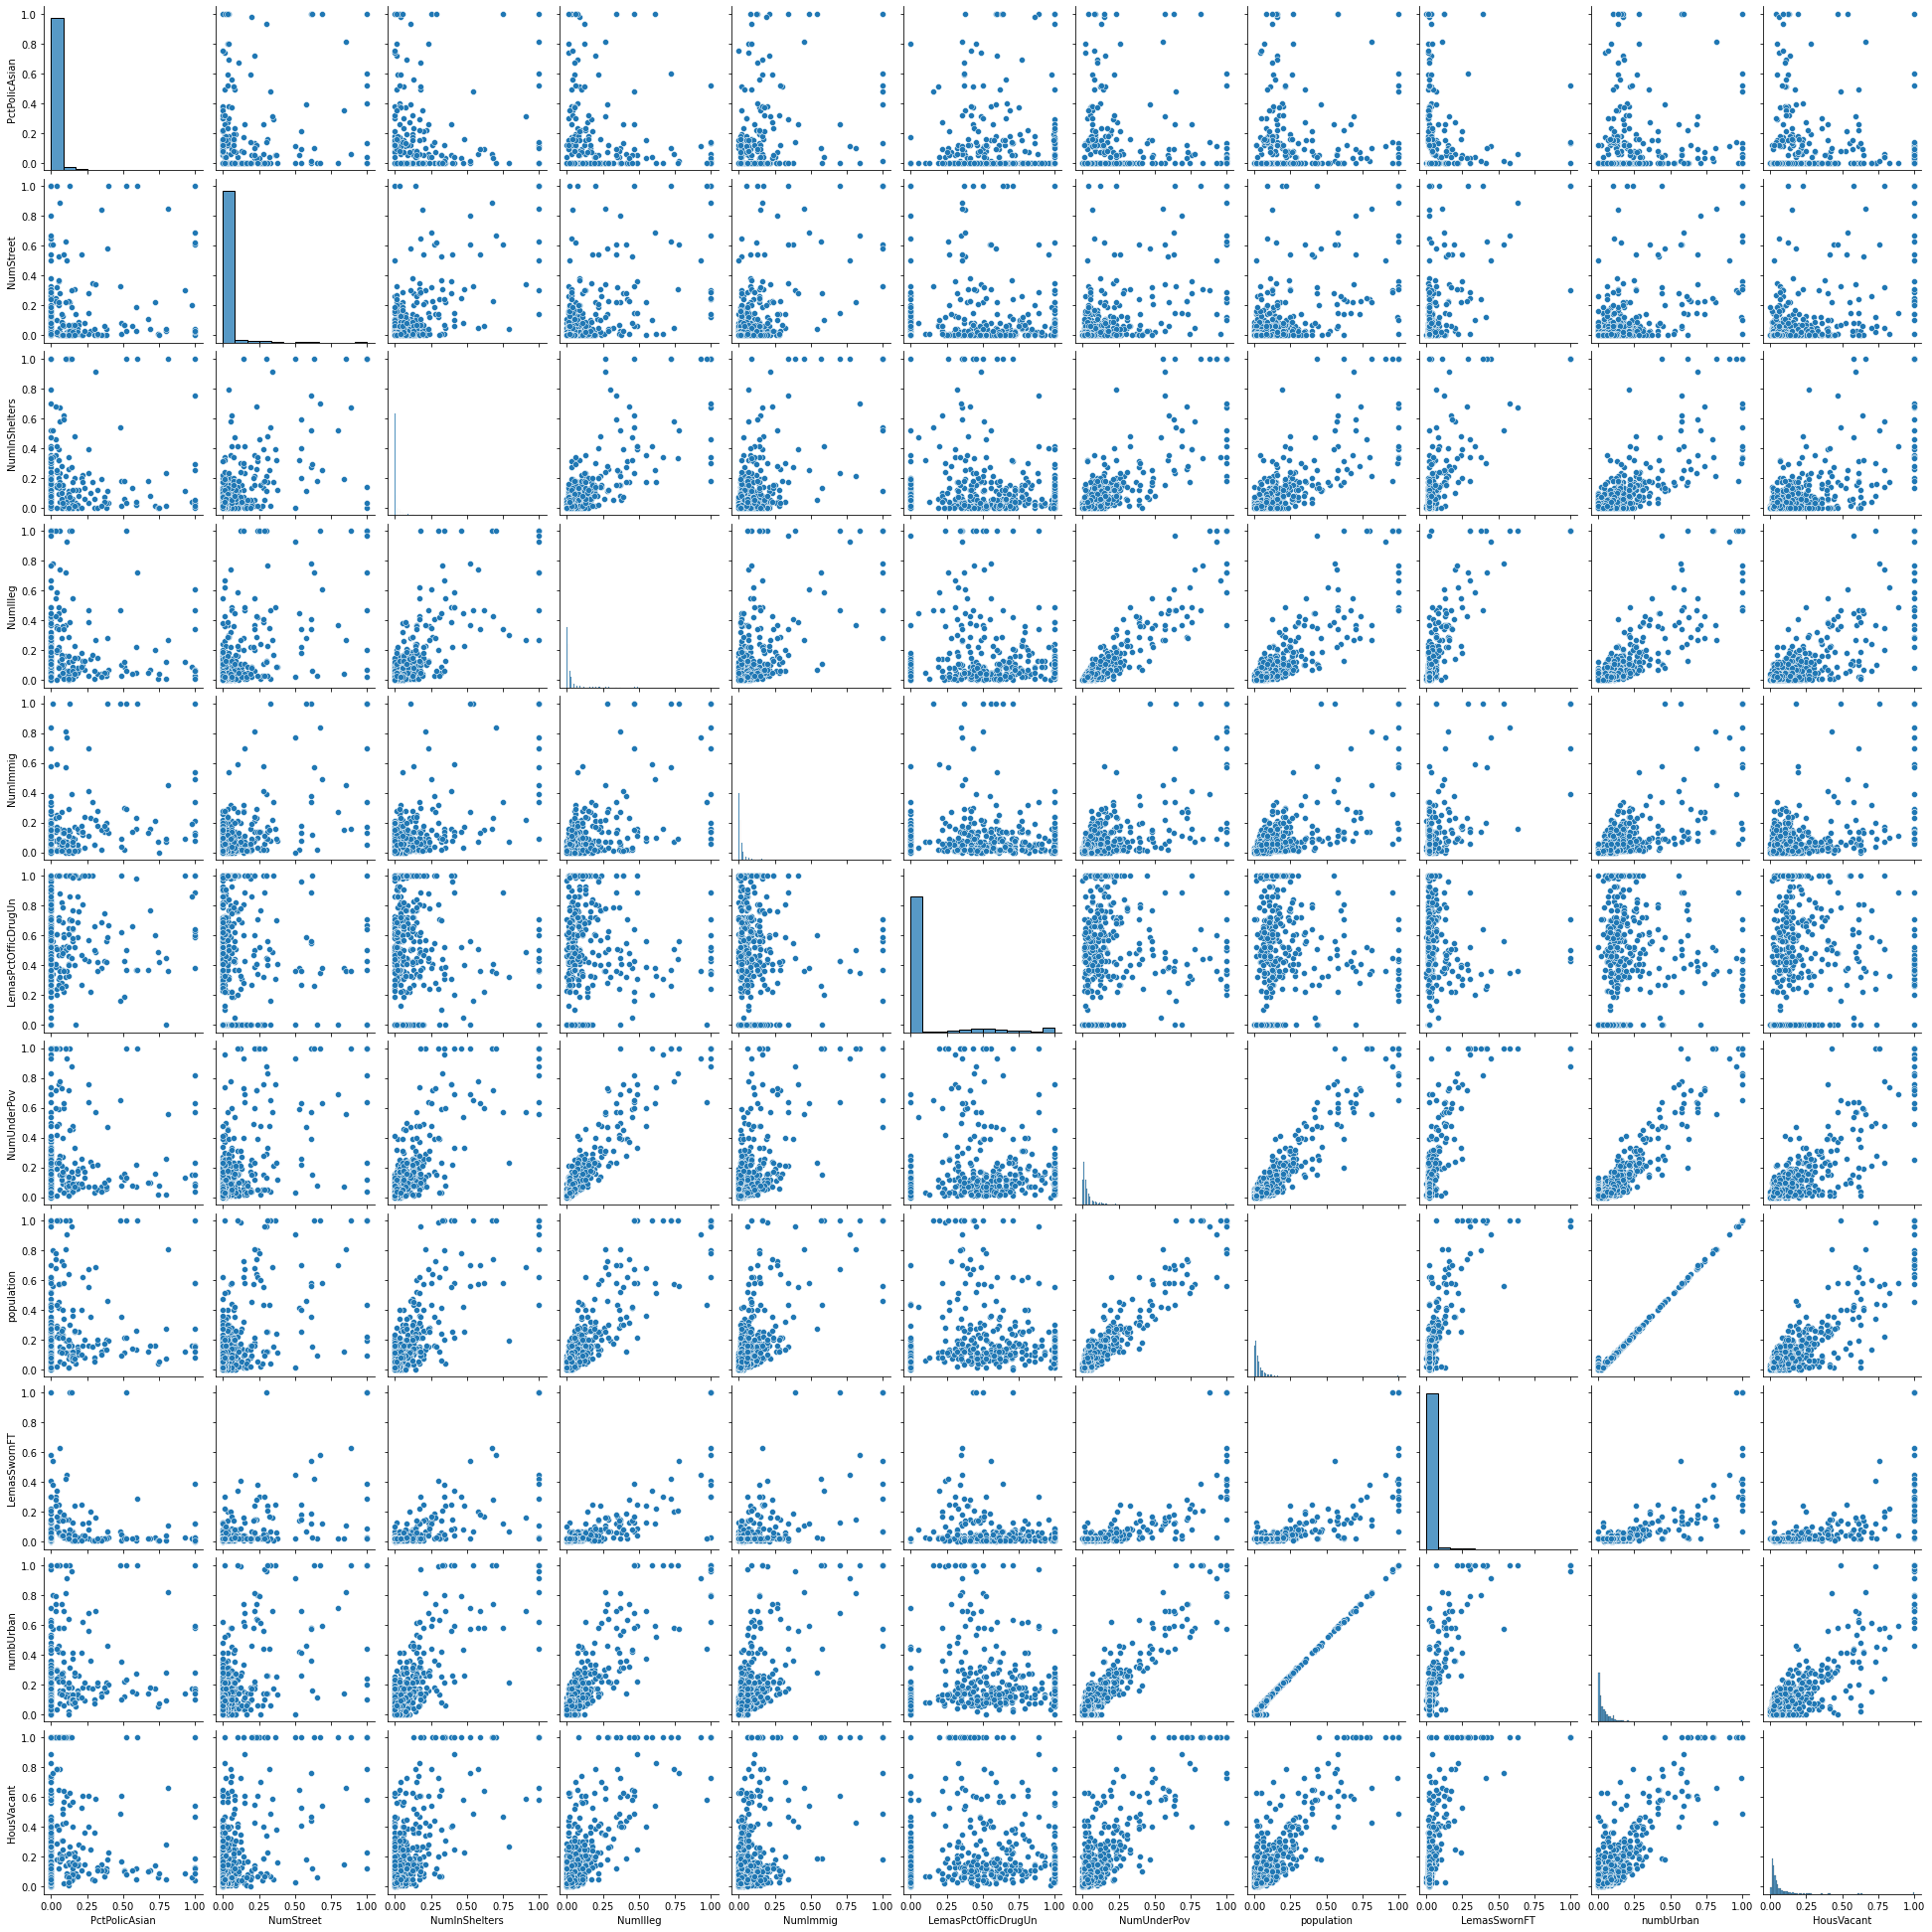

In [38]:
sns.pairplot(imp_df[list(top_features)])

<b> As can be seen from scatter plots, some of the pairs of the features are higly correlated. For example, 
(numbUrban & population), (numbUrban & NumUnderPov), etc. Since scatter plot doesnt contain our target variable ViolentCrimesPerPop, we cannot say if these features would be significant in predicting the label </b>

<AxesSubplot:>

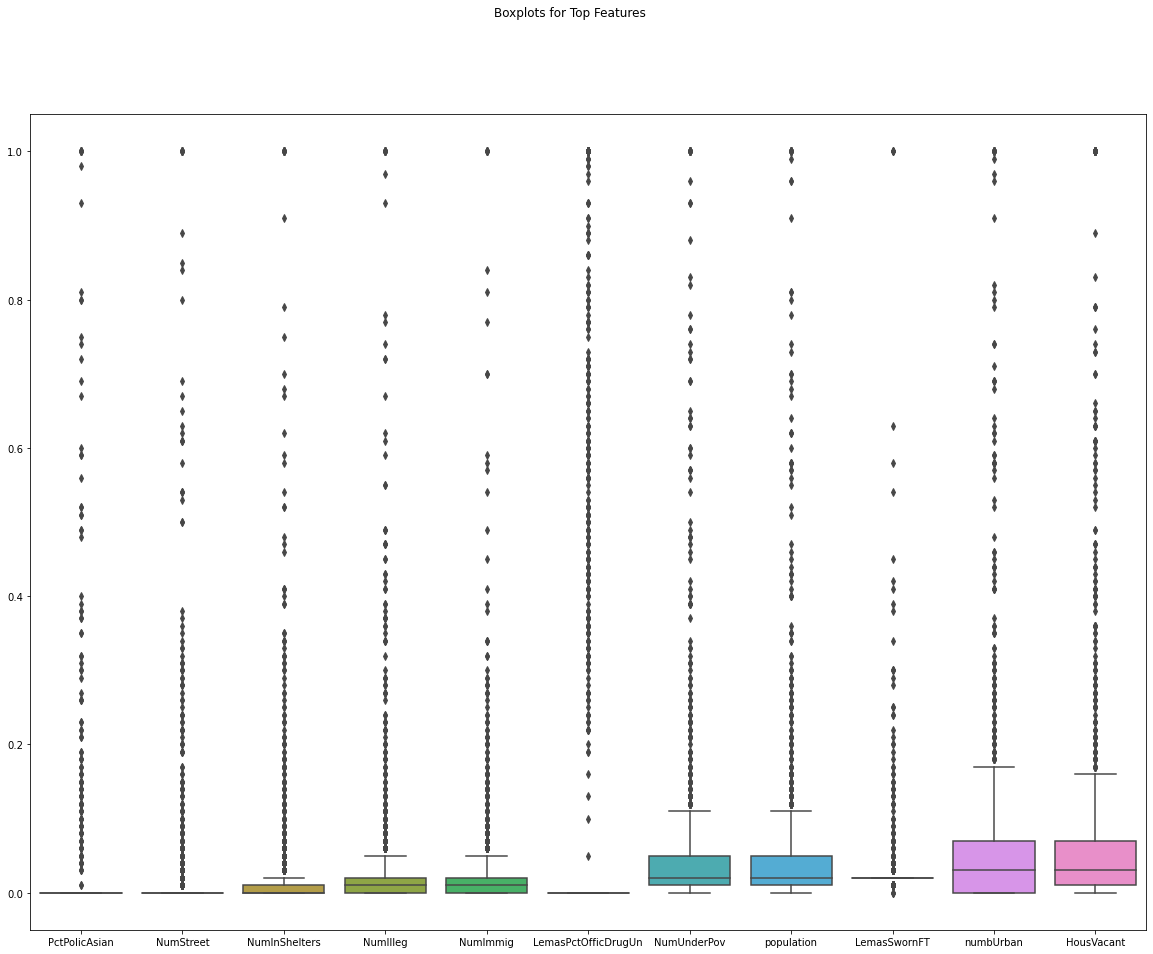

In [39]:
fig, axes = plt.subplots(figsize=(20,15))
fig.suptitle('Boxplots for Top Features')
sns.boxplot(ax=axes, data=imp_df[list(top_features)])

#### (f) Fit a linear model using least squares to the training set and report the test error. 

In [40]:
x_train = train_df[train_df.columns.drop(['ViolentCrimesPerPop'])]
y_train = train_df['ViolentCrimesPerPop']
x_test = test_df[test_df.columns.drop(['ViolentCrimesPerPop'])]
y_test = test_df['ViolentCrimesPerPop']

In [41]:
reg = linear_model.LinearRegression()

In [42]:
reg.fit(x_train, y_train)

LinearRegression()

In [43]:
y_pred = reg.predict(x_test)

In [44]:
test_error = mean_squared_error(y_test, y_pred)

In [45]:
print_bold(f"Test error obtained on linear model is {test_error}")

Test error obtained on linear model is 1.7579716884024877e+17


#### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [47]:
ridge_cv = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], store_cv_values=True).fit(x_train, y_train)

In [48]:
ridge_cv.alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [49]:
ridge_cv.cv_values_

array([[2.64843976e-03, 2.48902355e-03, 1.92128759e-03, 8.75195190e-04,
        1.72139782e-07],
       [1.87020340e-01, 1.85166451e-01, 1.77896393e-01, 1.68084441e-01,
        1.46946945e-01],
       [4.73413470e-03, 4.74083318e-03, 4.97031323e-03, 6.56655190e-03,
        7.65170720e-03],
       ...,
       [1.14477772e-01, 1.15252543e-01, 1.17264979e-01, 1.15108357e-01,
        1.02316079e-01],
       [1.76834464e-05, 1.07580120e-05, 1.03923305e-07, 1.71834992e-06,
        2.72699745e-05],
       [7.80336478e-02, 7.85955758e-02, 7.85522484e-02, 6.53365929e-02,
        5.26053341e-02]])

In [57]:
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

In [58]:
ridge_cv.alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [59]:
cv_mse

array([0.02011555, 0.01997729, 0.01957509, 0.01913098, 0.01923007])

In [60]:
ridge_cv.alpha_ # best alpha

1.0

In [61]:
y_pred = ridge_cv.predict(x_test) # alpha = 1 selected 

In [62]:
test_error = mean_squared_error(y_test, y_pred)

In [63]:
print_bold(f"Test error obtained on ridge reg model is {test_error} with alpha = {ridge_cv.alpha_}")

Test error obtained on ridge reg model is 0.017630963071697474 with alpha = 1.0


#### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [64]:
lasso_cv = linear_model.LassoCV().fit(x_train, y_train)

In [65]:
lasso_cv.alphas_

array([4.07815216e-02, 3.80329835e-02, 3.54696877e-02, 3.30791495e-02,
       3.08497255e-02, 2.87705573e-02, 2.68315180e-02, 2.50231635e-02,
       2.33366860e-02, 2.17638715e-02, 2.02970594e-02, 1.89291055e-02,
       1.76533472e-02, 1.64635707e-02, 1.53539811e-02, 1.43191742e-02,
       1.33541097e-02, 1.24540874e-02, 1.16147236e-02, 1.08319301e-02,
       1.01018943e-02, 9.42106042e-03, 8.78611248e-03, 8.19395791e-03,
       7.64171257e-03, 7.12668672e-03, 6.64637189e-03, 6.19842866e-03,
       5.78067532e-03, 5.39107715e-03, 5.02773659e-03, 4.68888397e-03,
       4.37286889e-03, 4.07815216e-03, 3.80329835e-03, 3.54696877e-03,
       3.30791495e-03, 3.08497255e-03, 2.87705573e-03, 2.68315180e-03,
       2.50231635e-03, 2.33366860e-03, 2.17638715e-03, 2.02970594e-03,
       1.89291055e-03, 1.76533472e-03, 1.64635707e-03, 1.53539811e-03,
       1.43191742e-03, 1.33541097e-03, 1.24540874e-03, 1.16147236e-03,
       1.08319301e-03, 1.01018943e-03, 9.42106042e-04, 8.78611248e-04,
      

In [66]:
lasso_cv.alpha_ # best alpha

0.00012454087437758504

In [67]:
name_coef_ = pd.DataFrame({'feature_name': x_train.columns, 'coef' : lasso_cv.coef_})

In [68]:
name_coef_

,feature_name,coef
0,population,-0.000000
1,householdsize,0.000000
2,racepctblack,0.267420
3,racePctWhite,-0.000000
4,racePctAsian,-0.014735
...,...,...
117,PolicOperBudg,-0.000000
118,LemasPctPolicOnPatr,0.015577
119,LemasGangUnitDeploy,0.036463
120,LemasPctOfficDrugUn,0.000000


In [69]:
lasso_cv.coef_

array([-0.        ,  0.        ,  0.26742002, -0.        , -0.01473526,
        0.        ,  0.05883789, -0.24917282,  0.        ,  0.        ,
       -0.        ,  0.04048254,  0.        , -0.07810023,  0.02533441,
       -0.09738956,  0.04756999,  0.03832589, -0.10698276,  0.        ,
       -0.        , -0.05351655, -0.02124496, -0.0304313 ,  0.02846885,
        0.02272535,  0.02209014, -0.        , -0.13715972, -0.0170335 ,
        0.        ,  0.        , -0.        ,  0.12982072, -0.01446905,
        0.        ,  0.00999408,  0.        ,  0.11338275,  0.12445323,
       -0.07295793, -0.        ,  0.        , -0.        , -0.19803654,
       -0.03973818, -0.0082421 ,  0.        , -0.12746784, -0.07933243,
        0.10115047, -0.0819462 , -0.00037302, -0.        , -0.        ,
       -0.00378719, -0.        ,  0.        ,  0.        ,  0.03593344,
        0.        , -0.06829709, -0.        , -0.05439953,  0.03249483,
       -0.        , -0.        , -0.0538859 ,  0.20995718,  0.05

In [70]:
selected_features = list(name_coef_[name_coef_['coef'] != 0]['feature_name']) # coefficient not 0 means selected

In [71]:
print(f"List of Selected Features: ")
selected_features

List of Selected Features: 


['racepctblack',
 'racePctAsian',
 'agePct12t21',
 'agePct12t29',
 'pctUrban',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctEmploy',
 'PctEmplManu',
 'PctOccupManu',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec10',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctHousLess3BR',
 'MedNumBR',
 'HousVacant',
 'PctHousOccup',
 'PctVacantBoarded',
 'PctVacMore6Mos',
 'MedYrHousBuilt',
 'PctHousNoPhone',
 'PctWOFullPlumb',
 'OwnOccLowQuart',
 'RentLowQ',
 'MedRent',
 'MedRentPctHousInc',
 'MedOwnCostPctInc',
 'MedOwnCostPctIncNoMtg',
 'NumInShelters',
 'NumStreet',
 'PctForeignBorn'

In [72]:
y_pred = lasso_cv.predict(x_test)

In [73]:
test_error = mean_squared_error(y_test, y_pred)

In [74]:
print_bold(f"Test error obtained on lasso reg model is {test_error} with alpha = {lasso_cv.alpha_}")

Test error obtained on lasso reg model is 0.017619962821141737 with alpha = 0.00012454087437758504


**Now Standardizing the features:**

In [75]:
scalar = StandardScaler()

In [76]:
x_train = train_df[train_df.columns.drop(['ViolentCrimesPerPop'])]
y_train = train_df['ViolentCrimesPerPop']
x_test = test_df[test_df.columns.drop(['ViolentCrimesPerPop'])]
y_test = test_df['ViolentCrimesPerPop']

In [77]:
x_train = pd.DataFrame(scalar.fit_transform(x_train))
x_train.columns = list(imp_df.columns)[:-1]
x_test = pd.DataFrame(scalar.fit_transform(x_test))
x_test.columns = list(imp_df.columns)[:-1]

In [78]:
lasso_cv = linear_model.LassoCV().fit(x_train, y_train)

In [79]:
lasso_cv.alpha_ # best alpha

0.0007630833878262516

In [80]:
name_coef_ = pd.DataFrame({'feature_name': x_train.columns, 'coef' : lasso_cv.coef_})

In [81]:
name_coef_

,feature_name,coef
0,population,-0.000000
1,householdsize,0.000000
2,racepctblack,0.067274
3,racePctWhite,-0.000000
4,racePctAsian,-0.000887
...,...,...
117,PolicOperBudg,0.000000
118,LemasPctPolicOnPatr,0.001776
119,LemasGangUnitDeploy,0.006132
120,LemasPctOfficDrugUn,-0.000000


In [82]:
selected_features = list(name_coef_[name_coef_['coef'] != 0]['feature_name']) # coefficient not 0 means selected

In [83]:
print(f"List of Selected Features: ")
selected_features

List of Selected Features: 


['racepctblack',
 'racePctAsian',
 'agePct12t21',
 'agePct12t29',
 'pctUrban',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctEmploy',
 'PctEmplManu',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRec5',
 'PctImmigRec10',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctHousLess3BR',
 'HousVacant',
 'PctHousOccup',
 'PctVacantBoarded',
 'PctVacMore6Mos',
 'MedYrHousBuilt',
 'PctHousNoPhone',
 'PctWOFullPlumb',
 'RentLowQ',
 'MedRent',
 'MedRentPctHousInc',
 'MedOwnCostPctInc',
 'MedOwnCostPctIncNoMtg',
 'NumInShelters',
 'NumStreet',
 'PctForeignBorn',
 'PctSameCity85',
 'LemasSwFTFieldPerPop',
 'Lema

In [84]:
y_pred = lasso_cv.predict(x_test)

In [85]:
test_error = mean_squared_error(y_test, y_pred)

In [86]:
print_bold(f"Test error obtained on lasso reg model after standardization of fetaures is {test_error} with alpha = {lasso_cv.alpha_}")

Test error obtained on lasso reg model after standardization of fetaures is 0.01787350582342028 with alpha = 0.0007630833878262516


**As we observe, the test error after standardization is very slightly greater than before standardization. But we can say that we are getting similar results on both of them. After standardization the number of selected features reduced from 74 to 72.**

#### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [87]:
x_train = train_df[train_df.columns.drop(['ViolentCrimesPerPop'])]
y_train = train_df['ViolentCrimesPerPop']
x_test = test_df[test_df.columns.drop(['ViolentCrimesPerPop'])]
y_test = test_df['ViolentCrimesPerPop']

In [88]:
#https://www.statology.org/principal-components-regression-in-python/
pcr_results = []
pca = PCA()
x_reduced = pca.fit_transform(x_train)
cross_val = KFold(n_splits=5, shuffle=True)
lin_reg = linear_model.LinearRegression()
cv_mse = []
cv_score = -1*cross_val_score(lin_reg, np.ones((len(x_reduced),1)), y_train.ravel(),\
                           cv=cross_val, scoring='neg_mean_squared_error').mean()
pcr_results.append({"NumOfPrincipalComponents":0 ,"CV MSE":cv_score})
for m in np.arange(1, 123):
    cv_score = -1*cross_val_score(lin_reg, x_reduced[:, :m], y_train.ravel(),\
                           cv=cross_val, scoring='neg_mean_squared_error').mean()
    pcr_results.append({"NumOfPrincipalComponents":m ,"CV MSE":cv_score})
results_pcr_df = pd.DataFrame(pcr_results)

In [89]:
results_pcr_df.sort_values(by=['CV MSE'])

,NumOfPrincipalComponents,CV MSE
96,96,0.019424
92,92,0.019493
80,80,0.019498
72,72,0.019504
97,97,0.019559
...,...,...
4,4,0.023986
3,3,0.027165
2,2,0.030460
1,1,0.037934


**As observed from the above results, M chosen by Cross validation is 100. Building our model now**

In [90]:
x_reduced_train_100 = x_reduced[:, :100]

In [91]:
lin_reg.fit(x_reduced_train_100, y_train)

LinearRegression()

In [92]:
x_reduced_test_100 = pca.transform(x_test)[:,:100]

In [93]:
y_pred = lin_reg.predict(x_reduced_test_100)

In [94]:
test_error = mean_squared_error(y_test, y_pred)

In [95]:
print_bold(f"Test error obtained on PCA regressor is {test_error} with M = 100")

Test error obtained on PCA regressor is 0.018244877257424963 with M = 100


#### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation

In [96]:
alphas=[1e-4,1e-3, 1e-2, 1e-1, 1, 10,100]

In [97]:
xgb_results = []
cross_val = KFold(n_splits=5, shuffle=True)
for alpha in alphas:
    xgb_tree = XGBRegressor(alpha=alpha)
    cv_score = -1*cross_val_score(xgb_tree, x_train, y_train, cv=cross_val, scoring='neg_mean_squared_error').mean()
    xgb_results.append({"Alpha":alpha ,"CV MSE":cv_score})

In [98]:
results_xgb_df = pd.DataFrame(xgb_results)
results_xgb_df.sort_values(by=['CV MSE'])

,Alpha,CV MSE
4,1.0000,0.020740
5,10.0000,0.022131
2,0.0100,0.022565
0,0.0001,0.022612
3,0.1000,0.023481
1,0.0010,0.023758
6,100.0000,0.037825


In [99]:
xgb_tree = XGBRegressor(alpha=1)
xgb_tree.fit(x_train, y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [100]:
y_pred = xgb_tree.predict(x_test)

In [101]:
test_error = mean_squared_error(y_test, y_pred)

In [102]:
print('\033[1m'f"Test error obtained on XGBoost model is {test_error} with alpha = 1" '\033[0m')

Test error obtained on XGBoost model is 0.01731536423195941 with alpha = 1
